# MPI calibration: comparison between the classical calibration and the ring experiment

In [1]:
import io
import os
import zipfile
import pandas
import yaml
from plotnine import *
import plotnine
import sys
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x, usecols=None):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    return df

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)), Loader=yaml.BaseLoader)

def get_mpi(zip_name):
    info = get_yaml(zip_name, 'info.yaml')
    versions = set()
    for k in info.keys():
        if k.endswith('.grid5000.fr'):
            versions.add(info[k]['mpi'])
    assert len(versions) == 1
    version = versions.pop().split(' ')[-1]
    install = get_yaml(zip_name, info['installfile'])
    try:
        requested_mpi = install['openmpi']
        assert requested_mpi == version
        version = f'{version} (source)'
    except KeyError: # old peanut version where we used the Debian package
        version = f'{version} (debian)'
    return version

def load_ringrong(zip_name):
    df = read_csv(zip_name, 'result.csv').reset_index()
    df['msg_size'] = df['size']
    df.drop('size', inplace=True, axis=1)
    df['sub_id'] = df['index'] // 2 # identifying the MPI_Send and MPI_Recv that are part of a same ping-pong
    df['op_kind'] = df['sub_id'] % 2 # each rank makes two distincts ping-pong: one recv-send with the previous rank and one send-recv with the next rank
    df.loc[df['op_kind'] == 0, 'op_kind'] = 'recv-send'
    df.loc[df['op_kind'] == 1, 'op_kind'] = 'send-recv'
    remote_next = {31, 63}
    remote_prev = {0, 32}
    df.loc[df['rank'].isin(remote_prev) & (df['op_kind'] == 'recv-send'), 'experiment'] = 'remote'
    df.loc[~df['rank'].isin(remote_prev) & (df['op_kind'] == 'recv-send'), 'experiment'] = 'loopback'
    df.loc[df['rank'].isin(remote_next) & (df['op_kind'] == 'send-recv'), 'experiment'] = 'remote'
    df.loc[~df['rank'].isin(remote_next) & (df['op_kind'] == 'send-recv'), 'experiment'] = 'loopback'
    df_send = df[df['function'] == 'MPI_Send']
    df_recv = df[df['function'] == 'MPI_Recv']
    df_ringrong = df_send.set_index(['rank', 'op_id', 'sub_id', 'op_kind', 'experiment', 'msg_size']).join(df_recv.set_index(['rank', 'op_id', 'sub_id', 'op_kind', 'experiment', 'msg_size']), lsuffix='_send', rsuffix='_recv').reset_index()
    df_ringrong['duration'] = df_ringrong['duration_send'] + df_ringrong['duration_recv']
    info = get_yaml(zip_name, 'info.yaml')
    install = get_yaml(zip_name, info['installfile'])
    mpi = get_mpi(zip_name)
    for df in [df_send, df_recv, df_ringrong]:
        df['cluster'] = info['cluster']
        df['mpi'] = mpi
        for key in ['matrix_size', 'perf_pct']:
            df[key] = int(install[key])
        for key in ['hyperthreading', 'turboboost', 'idle_state']:
            df[key] = install[key]
    return {
        'ringrong': df_ringrong,
        'send': df_send,
        'recv': df_recv
    }

def extract_zip(zip_name):
    '''Taken from https://stackoverflow.com/a/10909016/4110059'''
    input_zip = zipfile.ZipFile(zip_name)
    result = {}
    deployment = yaml.load(input_zip.read('info.yaml'), Loader=yaml.BaseLoader)['deployment']
    experiment = zip_name
    if '/' in experiment:
        experiment = experiment[experiment.index('/')+1:]
    experiment = experiment[:experiment.index('_')]
    for name in input_zip.namelist():
        if name.endswith('.csv'):
            dataframe = pandas.read_csv(io.BytesIO(input_zip.read(name)), names = ['op', 'msg_size', 'start', 'duration'])
            dataframe['experiment'] = experiment
            dataframe['type'] = name
            dataframe['deployment'] = deployment
            dataframe['index'] = range(len(dataframe))
            result[name] = dataframe
        elif name.endswith('.yaml'):
            result[name] = yaml.load(input_zip.read(name), Loader=yaml.BaseLoader)
        else:
            result[name] = input_zip.read(name)
    return result

def load_classical(zip_name):
    result = extract_zip(zip_name)
    # Special processing for the Pingpong dataset
    df_pingpong = result['exp/exp_PingPong.csv']
    pingpong_send = df_pingpong[df_pingpong.op=='MPI_Send'].reset_index(drop=True)
    pingpong_recv = df_pingpong[df_pingpong.op=='MPI_Recv'].reset_index(drop=True)
    df_pingpong = pandas.DataFrame(dict(op = 'PingPong',
                       msg_size = pingpong_send.msg_size,
                       start    = pingpong_send.start,
                       duration = pingpong_recv.duration + pingpong_send.duration
                  ))
    nb_nodes = len(get_yaml(zip_name, 'oarstat.yaml')['assigned_network_address'])
    if nb_nodes == 1:
        experiment = 'loopback'
    elif nb_nodes == 2:
        experiment = 'remote'
    else:
        assert False
    installfile = get_yaml(zip_name, 'info.yaml')['installfile']
    background_dgemm = get_yaml(zip_name, installfile)['background_stress']
    result = {
        'pingpong': df_pingpong,
        'send'  : pingpong_send,
        'recv'  : pingpong_recv,
    }
    info = get_yaml(zip_name, 'info.yaml')
    mpi = get_mpi(zip_name)
    for df in result.values():
        df['experiment'] = experiment
        df['mpi'] = mpi
        df['background_dgemm'] = background_dgemm
    return result

In [2]:
directories = ['250MB/1/ring/']
archives = [os.path.join(directory, f) for directory in directories for f in os.listdir(directory)]
df_ringrong = pandas.concat([load_ringrong(f)['recv'] for f in archives])
df_ringrong = df_ringrong[(df_ringrong['op_kind'] == 'recv-send') & (df_ringrong['rank'] != 0)]
df_ringrong['kind'] = 'ringrong'
df_ringrong

,index,function,rank,op_id,timestamp,duration,msg_size,sub_id,op_kind,experiment,cluster,mpi,matrix_size,perf_pct,hyperthreading,turboboost,idle_state,kind
400,400,MPI_Recv,10,0,1.185648,0.073001,268435456,200,recv-send,loopback,dahu,2.0.2 (debian),0,100,false,true,false,ringrong
404,404,MPI_Recv,10,1,10.096957,0.064184,268435456,202,recv-send,loopback,dahu,2.0.2 (debian),0,100,false,true,false,ringrong
408,408,MPI_Recv,10,2,19.062844,0.073161,268435456,204,recv-send,loopback,dahu,2.0.2 (debian),0,100,false,true,false,ringrong
412,412,MPI_Recv,10,3,28.226375,0.073145,268435456,206,recv-send,loopback,dahu,2.0.2 (debian),0,100,false,true,false,ringrong
416,416,MPI_Recv,10,4,37.374775,0.072962,268435456,208,recv-send,loopback,dahu,2.0.2 (debian),0,100,false,true,false,ringrong
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25580,25580,MPI_Recv,63,95,1304.434060,0.149291,268435456,12790,recv-send,loopback,dahu,2.0.2 (debian),128,100,false,true,false,ringrong
25584,25584,MPI_Recv,63,96,1317.959521,0.152459,268435456,12792,recv-send,loopback,dahu,2.0.2 (debian),128,100,false,true,false,ringrong
25588,25588,MPI_Recv,63,97,1331.503782,0.151617,268435456,12794,recv-send,loopback,dahu,2.0.2 (debian),128,100,false,true,false,ringrong
25592,25592,MPI_Recv,63,98,1345.149075,0.152126,268435456,12796,recv-send,loopback,dahu,2.0.2 (debian),128,100,false,true,false,ringrong


In [3]:
directories = ['250MB/1/classical/']
archives = [os.path.join(directory, f) for directory in directories for f in os.listdir(directory)]
df_classical = pandas.concat([load_classical(f)['recv'] for f in archives])
df_classical['kind'] = 'classical'
df_classical

,op,msg_size,start,duration,experiment,type,deployment,index,mpi,background_dgemm,kind
0,MPI_Recv,268435456,0.000285,0.127532,loopback,exp/exp_PingPong.csv,debian9-x64-base,1,2.0.2 (debian),True,classical
1,MPI_Recv,268435456,0.255832,0.055260,loopback,exp/exp_PingPong.csv,debian9-x64-base,3,2.0.2 (debian),True,classical
2,MPI_Recv,268435456,0.366392,0.055240,loopback,exp/exp_PingPong.csv,debian9-x64-base,5,2.0.2 (debian),True,classical
3,MPI_Recv,268435456,0.476986,0.055257,loopback,exp/exp_PingPong.csv,debian9-x64-base,7,2.0.2 (debian),True,classical
4,MPI_Recv,268435456,0.587657,0.055359,loopback,exp/exp_PingPong.csv,debian9-x64-base,9,2.0.2 (debian),True,classical
...,...,...,...,...,...,...,...,...,...,...,...
95,MPI_Recv,268435456,12.285877,0.069076,remote,exp/exp_PingPong.csv,debian9-x64-base,191,2.0.2 (debian),True,classical
96,MPI_Recv,268435456,12.413568,0.069037,remote,exp/exp_PingPong.csv,debian9-x64-base,193,2.0.2 (debian),True,classical
97,MPI_Recv,268435456,12.541155,0.069017,remote,exp/exp_PingPong.csv,debian9-x64-base,195,2.0.2 (debian),True,classical
98,MPI_Recv,268435456,12.668788,0.069101,remote,exp/exp_PingPong.csv,debian9-x64-base,197,2.0.2 (debian),True,classical


MPI_Recv


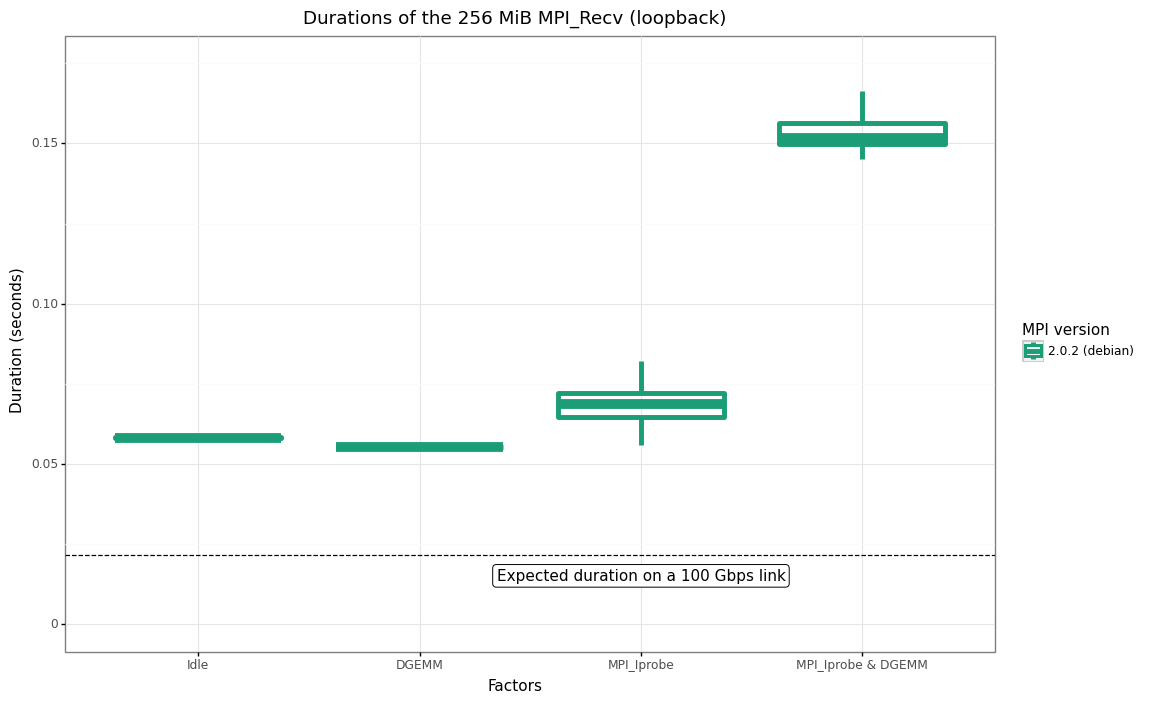

<ggplot: (8785624378102)>


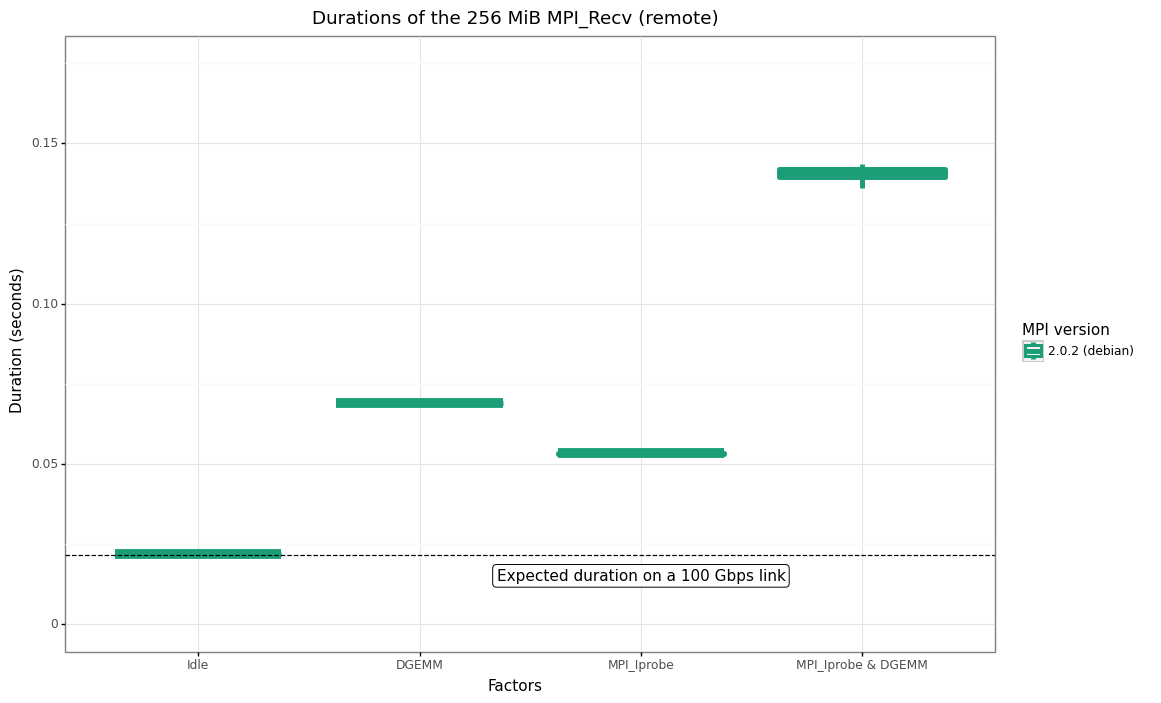

<ggplot: (-9223363251230496782)>


In [4]:
bw  = 12.5*1e9
lat = 0.1*1e-6

tmp = pandas.concat([df_ringrong, df_classical])
tmp['x'] = tmp['experiment'] + ':' + tmp['kind'] + ':' + tmp['matrix_size'].astype(str) + ':' + tmp['background_dgemm'].astype(str)
tmp.loc[(tmp['kind'] == 'classical') & (tmp['background_dgemm'] == 'False') , 'x'] = 'Idle'
tmp.loc[(tmp['kind'] == 'classical') & (tmp['background_dgemm'] == 'True') , 'x'] = 'DGEMM'
tmp.loc[(tmp['kind'] == 'ringrong') & (tmp['matrix_size'] == 0), 'x'] = 'MPI_Iprobe'
tmp.loc[(tmp['kind'] == 'ringrong') & (tmp['matrix_size'] == 128), 'x'] = 'MPI_Iprobe & DGEMM'

cat = ['Idle', 'DGEMM', 'MPI_Iprobe', 'MPI_Iprobe & DGEMM']
tmp['x'] = pandas.Categorical(tmp['x'], categories=cat, ordered=True)

size = list(tmp['msg_size'].unique())
assert len(size) == 1
size = size[0]
theoretical_duration = size/(bw) + lat

function = df_ringrong['function'].unique()
assert len(function) == 1
function = function[0]
print(function)

for exp in tmp['experiment'].unique():
    print(ggplot(tmp[tmp['experiment'] == exp])
        + aes(x='x', y='duration', color='mpi')
        + geom_boxplot(outlier_alpha=0, alpha=0, size=2)
        + theme_bw()
        + expand_limits(y=[0, tmp['duration'].max()])
        + geom_hline(yintercept=theoretical_duration, linetype='dashed')
        + labs(x='Factors', y='Duration (seconds)', color='MPI version')
        + scale_color_brewer(type='qual', palette='Dark2')
        + annotate('label', x=3, y=theoretical_duration*0.7, label='Expected duration on a 100 Gbps link')
        + ggtitle(f'Durations of the {size/(2**20):.0f} MiB {function} ({exp})')
    )

In [5]:
tmp['background'] = tmp['x']
x = tmp[['duration', 'msg_size', 'experiment', 'kind', 'background']]
x.to_csv('/tmp/communication_computation_interference.csv', index=False)
x

,duration,msg_size,experiment,kind,background
400,0.073001,268435456,loopback,ringrong,MPI_Iprobe
404,0.064184,268435456,loopback,ringrong,MPI_Iprobe
408,0.073161,268435456,loopback,ringrong,MPI_Iprobe
412,0.073145,268435456,loopback,ringrong,MPI_Iprobe
416,0.072962,268435456,loopback,ringrong,MPI_Iprobe
...,...,...,...,...,...
95,0.069076,268435456,remote,classical,DGEMM
96,0.069037,268435456,remote,classical,DGEMM
97,0.069017,268435456,remote,classical,DGEMM
98,0.069101,268435456,remote,classical,DGEMM
